# Notebook for Final Project

## Package Import

In [32]:
# Basic
import numpy as np # linear algebra
import scipy as sp
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

## Data Exploration and Preprocessing

Read data and look at the variables we have

In [33]:
# Import Data
df = pd.read_json("../data/train.json")

In [34]:
print df.shape

(49352, 15)


In [35]:
# Look at the first few rows
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


## Split Training Set and Test Set

We are spliting the available data into training set and test set

In [36]:
df_y = df[['price']]
df_X = df.drop('price',axis=1)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=0)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(39481, 14) (9871, 14) (39481, 1) (9871, 1)


## Training Data Manipulation

From now on, we use the training data for modeling and validation.

Select Numeric Data

In [38]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X_train_numeric = X_train.select_dtypes(include=numerics)
X_train_numeric.head()

,bathrooms,bedrooms,latitude,listing_id,longitude
100514,1.0,2,40.7080,6861664,-74.0149
42844,1.0,1,40.7289,7115500,-74.0029
37508,1.0,0,40.7347,7153691,-74.0013
70450,1.0,0,40.7911,6996200,-73.9735
110961,2.0,2,40.7592,6862280,-73.9948


Select Text Data

In [39]:
X_train_string = X_train.select_dtypes(include=['object'])
X_train_string.head()

,building_id,created,description,display_address,features,interest_level,manager_id,photos,street_address
100514,bb8658a3e432fb62a440615333376345,2016-04-12 06:01:01,Building Characteristics:Twenty-four hour conc...,Washington Place,"[Doorman, Fitness Center, Laundry in Unit, Dis...",low,92aa3b535f48ec05903a3b7fcdafd411,[https://photos.renthop.com/2/6861664_28951e60...,90 Washington Place
42844,5855d5dfcaca9da6cacb1f389fd383bd,2016-06-06 02:52:14,Perfect for NYU StudentsGreat 1 bedroom in PRI...,West Houston,[Hardwood Floors],low,aea47aba66a01cf236746e209c2b7f88,[https://photos.renthop.com/2/7115500_ac16766c...,176 West Houston
37508,0,2016-06-13 01:18:15,This apartment is located in a walk up buildin...,Waverly Place,"[Fireplace, Pre-War, Dogs Allowed, Cats Allowed]",low,8b53ccf4338806ab1be3dd0267711649,[https://photos.renthop.com/2/7153691_ceaef03e...,189 Waverly Place
70450,b491b11c7eafd39aabdb9a9f0acf88b8,2016-05-11 05:29:34,Spacious Studio in a Full Service BLDGApartmen...,West 91st Street,"[Roof Deck, Doorman, Laundry in Building, High...",low,8600370dac7555a25d417e7f2dab6d1b,[https://photos.renthop.com/2/6996200_be863639...,212 West 91st Street
110961,0,2016-04-12 06:19:32,"Located in prime Midtown West/Clinton area, co...",West 42nd Street,"[Swimming Pool, Roof Deck, Dining Room, Doorma...",low,8262449f40e9117f7a9ea49b4a333993,[https://photos.renthop.com/2/6862280_c9d26202...,450 West 42nd Street


## Feature Extraction

Here we can create some new features derived from original features

#### Extract the number of "photos" and "features" for each listing

In [60]:
X_train_numeric.ix[:,'num_features']=X_train_string.ix[:,'features'].apply(len)
X_train_numeric.ix[:,'num_photos']=X_train_string.ix[:,'photos'].apply(len)

#### Extract the interest level

In [61]:
mm = {'low':0, 'medium':1, 'high':2}
X_train_numeric.ix[:,'interest_value']=X_train_string.ix[:,'interest_level'].apply(lambda x: mm[x])
X_train_numeric.iloc[0:10,:]

,bathrooms,bedrooms,latitude,listing_id,longitude,num_features,num_photos,interest_value
100514,1.0,2,40.7080,6861664,-74.0149,9,2,0
42844,1.0,1,40.7289,7115500,-74.0029,1,4,0
37508,1.0,0,40.7347,7153691,-74.0013,4,3,0
70450,1.0,0,40.7911,6996200,-73.9735,6,1,0
110961,2.0,2,40.7592,6862280,-73.9948,15,5,0
79824,1.0,2,40.7054,6986426,-74.0095,14,4,0
109338,1.0,0,40.7521,6904109,-74.0011,3,5,0
12632,2.0,4,40.8034,7229066,-73.9545,3,1,0
23600,4.0,4,40.7886,7218713,-73.9547,2,10,0
75968,1.0,2,40.7516,7060236,-73.9690,9,7,1


## Construct X and y

In [42]:
X = X_train_numeric.values # Use numeric data as features
y = y_train.values # Target Variable: price
print X.shape, y.shape

(39481, 7) (39481, 1)


## Feature Selection

To select numeric features, we have several choices:
1. Embeded Method: We can use some linear models penalized with the L1 norm to make unimportant features has coefficient of zero.
2. Filter Method: Preprocess the features by using F-test, Correlation Matrix, etc.
3. Wrapper Method: Run model on subsets and score them

I've tried the recursive feature elimination method, but takes too much time, so we can instead use Lasso feature selection for the numeric data

In [25]:
# Embeded Method: Lasso 
# Reference: Wikipedia-Feature Selection
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
estimator = Lasso()
estimator.fit(X,y)
selector = SelectFromModel(estimator, prefit=True, threshold=0.25)
X_new = selector.transform(X)
# n_features indicates the number of features we want
n_features = X_new.shape[1]
while n_features > 4:
    selector.threshold += 0.1
    X_new = selector.transform(X)
    n_features = X_new.shape[1]
print X_new.shape
print selector.get_support() # We can see that only the first two features "bedroom", "bathroom" remains

(39481, 4)
[ True  True  True False  True False False]


# Modeling

### Simplest Model: Linear Regression with L1-Regularization

In [26]:
# Import models
ls =Lasso(alpha=0.1)
ls.fit(X_new, y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

### Cross Validation

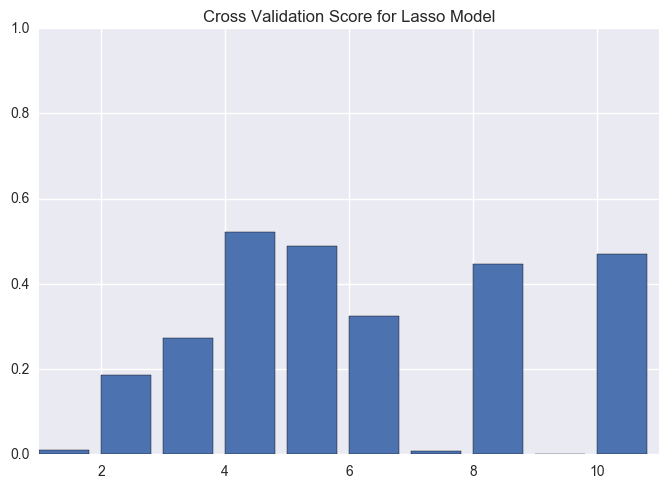

In [27]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ls, X, y, cv=10)
plt.bar(np.arange(1,11), scores)
plt.title('Cross Validation Score for Lasso Model')
plt.xlim(1,11)
plt.ylim(0,1)
plt.show()

The performance of this model is very ugly because we haven't do any model selection and feature engineering

## Evaluation

## Deployment